### Jonathan Bunch

20 November 2021

Bellevue University

DSC550-T301

---

# Final Project

In [2]:
# Import libraries.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score
from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeRegressor

In [3]:

def evaluate_model(predictor, x_test_set, y_test_set, model_name=None):
    """
    This function takes a fitted model and testing data sets and calculates evaluation metrics for the model.

    :param predictor: A fitted model or pipeline. Must have a "predict" method.
    :param x_test_set: The testing set for predictive features.
    :param y_test_set: The testing set for the target feature (true target values).
    :param model_name: Optional parameter for printing the name of the model in the results.
    """
    predicted_vals = predictor.predict(x_test_set)
    r2 = r2_score(y_test_set, predicted_vals)
    mae = mean_absolute_error(y_test_set, predicted_vals)
    mse = mean_squared_error(y_test_set, predicted_vals)
    evs = explained_variance_score(y_test_set, predicted_vals)
    # Print the results.
    if model_name:
        print('Evaluation Metrics for {} Model:'.format(model_name))
    else:
        print('Evaluation Metrics for Model:')
    print("R-Squared Score:            ", r2)
    print("Explained Variance Score:   ", evs)
    print("Mean Absolute Error:        ", mae)
    print("Mean Squared Error:         ", mse)
    print()
    return r2, evs, mae, mse


In [4]:
# Import data sets.
disney_raw = pd.read_csv("disney_movies_total_gross.csv")
fmi_raw = pd.read_csv("mortality_fertility_income.csv", decimal=',')
print(disney_raw.shape)
print(fmi_raw.shape)

(579, 6)
(217, 144)


In [5]:
# Disney movie dataset preparation:

# Drop irrelevant features.  I found previously that 'mpaa_rating' had too many missing values to be useful.
ddf_1 = disney_raw.drop(columns=['movie_title', 'total_gross', 'mpaa_rating'])
# As before, I will consider any observation that has a zero value for the adjusted profits to be a missing value.
ddf_1 = ddf_1[ddf_1.inflation_adjusted_gross != 0]
# Convert the date column to a datetime datatype to make it easier to work with.
ddf_1.release_date = ddf_1.release_date.astype(np.datetime64)
# I am going to create features from the month and year, and drop the orginal date column.
ddf_1.loc[:, 'year'] = ddf_1.release_date.apply(lambda x: x.year)
ddf_1.loc[:, 'month'] = ddf_1.release_date.apply(lambda x: x.month)
ddf_2 = ddf_1.drop(columns='release_date')
# Drop observations from before 1970.
ddf_2 = ddf_2[ddf_2.year >= 1970]
ddf_2 = ddf_2.reset_index(drop=True)
# Create dummy variables for the month of release.  I will also create dummy variables for the genre.
month_dummies = pd.get_dummies(ddf_2.month, prefix='month')
genre_dummies = pd.get_dummies(ddf_2.genre, prefix='genre')
# Join the dummy variables to the original dataframe.
ddf_3 = ddf_2.join([month_dummies, genre_dummies])
# Drop the original columns.
ddf_3 = ddf_3.drop(columns=['month', 'genre'])
# Finally, aggregate the yearly sum of each feature and re-organize the dataframe to represent yearly observations.
ddf_4 = ddf_3.groupby(['year']).sum()
ddf_4.head()

,inflation_adjusted_gross,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,...,genre_Black Comedy,genre_Comedy,genre_Concert/Performance,genre_Documentary,genre_Drama,genre_Horror,genre_Musical,genre_Romantic Comedy,genre_Thriller/Suspense,genre_Western
year,,,,,,,,,,,,,,,,,,,,,
1970,356362241,0,0,0,1,0,0,1,0,0,...,0,1,0,0,0,0,1,0,0,0
1971,91305448,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1975,131246872,0,0,0,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0
1977,363659174,1,0,0,0,0,2,0,0,0,...,0,2,0,0,0,0,0,0,0,0
1979,120377374,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
# Societal indicators dataset preparation:

# Isolate the data for the country of interest.
fmi_1 = fmi_raw[fmi_raw['Country Name'] == "United States"]
# Drop unnecessary columns.
fmi_1 = fmi_1.drop(columns=['Country Name', 'Country Code', 'Region']).reset_index(drop=True)
fmi_1.head()
# Use the Pandas "wide_to_long" method to "unpivot" these data.
fmi_1['id'] = fmi_1.index
fmi_2 = pd.wide_to_long(fmi_1, stubnames=['m', 'f', 'i'], i='id', j='year')
fmi_2 = fmi_2.reset_index(level='id', drop=True)
# Rename the columns.
fmi_3 = fmi_2.rename(columns={'m': 'mortality', 'f': 'fertility', 'i': 'income_per_cap'})
fmi_3.head()

,mortality,fertility,income_per_cap
year,,,
1970,19.9,2.480,4591.218634
1971,19.1,2.266,4891.985558
1972,18.3,2.010,5305.320034
1973,17.5,1.879,5912.942042
1974,16.7,1.835,6152.478813


In [7]:
# Combine the data sets.
cd_1 = ddf_4.join(fmi_3)
# Finalize the columns names. I will remove spaces and slashes, and convert all characters to lower case.
# I will also remove the 'month_' prefix to help streamline renaming of those columns in the following step.
df = cd_1.rename(lambda t: t.lower().replace(' ', '_').replace('/', '_or_').replace('month_', ''), axis=1)
df = df.rename(columns={'1': 'jan_release', '2': 'feb_release', '3': 'mar_release', '4': 'apr_release',
                        '5': 'may_release', '6': 'jun_release', '7': 'jul_release', '8': 'aug_release',
                        '9': 'sep_release', '10': 'oct_release', '11': 'nov_release', '12': 'dec_release'})
df.head()

,inflation_adjusted_gross,jan_release,feb_release,mar_release,apr_release,may_release,jun_release,jul_release,aug_release,sep_release,...,genre_documentary,genre_drama,genre_horror,genre_musical,genre_romantic_comedy,genre_thriller_or_suspense,genre_western,mortality,fertility,income_per_cap
year,,,,,,,,,,,,,,,,,,,,,
1970,356362241,0,0,0,1,0,0,1,0,0,...,0,0,0,1,0,0,0,19.9,2.480,4591.218634
1971,91305448,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,19.1,2.266,4891.985558
1975,131246872,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,16.0,1.774,6564.002627
1977,363659174,1,0,0,0,0,2,0,0,0,...,0,0,0,0,0,0,0,14.5,1.790,7990.411096
1979,120377374,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,13.2,1.808,9557.345962


In [8]:
# Model building and evaluation

# %%

# Assign the predictive and target features to new variables for convenience.
X, y = df.drop(columns="inflation_adjusted_gross"), df.inflation_adjusted_gross

In [9]:
# Split the data into training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=5)

# %%

# Create a list of k values to try for the SelectKBest method.
k_vals = [b for b in range(2, (len(X_train.columns)))]

# Iterate through different k values and fit a LassoCV model for each iteration to find the k value and features
# that provide the best model evaluation score.
model_scores = {}
for k in k_vals:
    kb_model = SelectKBest(f_regression, k=k)
    kb_model.fit(X_train, y_train)
    X_train_k = kb_model.transform(X_train)
    X_test_k = kb_model.transform(X_test)
    # Create and fit a linear regression model.
    model = make_pipeline(StandardScaler(), LinearRegression())
    model.fit(X_train_k, y_train)
    # Score the model.
    score = model.score(X_test_k, y_test)
    model_scores[k] = score

# Find the best score and corresponding k value.
best_k = max(model_scores, key=lambda key: model_scores[key])
# Use the best k value to feature-reduce-transform the X_train and X_test datasets.
selector = SelectKBest(f_regression, k=best_k)
selector.fit_transform(X_train, y_train)
selector.transform(X_test)
# Create new dataframes with the reduced number of features.
cols = selector.get_support(indices=True)
X_train = X_train.iloc[:, cols]
X_test = X_test.iloc[:, cols]
# Display a list of features that were removed.
removed_features = list(X.columns.difference(X_train.columns))
print('Features removed from the original predictive data set:')
print(removed_features)

Features removed from the original predictive data set:
['fertility', 'genre_black_comedy', 'genre_concert_or_performance', 'genre_documentary', 'genre_horror', 'genre_musical', 'genre_romantic_comedy', 'genre_western', 'jul_release', 'nov_release', 'sep_release']


In [10]:
# Create and fit an OLS linear regression model.
lin_reg_pipe = make_pipeline(StandardScaler(), LinearRegression())
lin_reg_pipe.fit(X_train, y_train)
# Create and fit a LassoCV regression model.
lassocv_pipe = make_pipeline(StandardScaler(), LassoCV(max_iter=50000))
lassocv_pipe.fit(X_train, y_train)
# Create and fit a decision tree regressor model.
dec_tree_pipe = make_pipeline(StandardScaler(), DecisionTreeRegressor())
dec_tree_pipe.fit(X_train, y_train)
# Create a list of models and corresponding names to iterate through.
models = [lin_reg_pipe, lassocv_pipe, dec_tree_pipe]
model_names = ["OLS Regression", "LassoCV Regression", "Decision Tree Regressor"]
# Evaluate the models.
scores = {}
for m, n in zip(models, model_names):
    scores[n] = evaluate_model(m, X_test, y_test, n)
# Create a dataframe of the scores to streamline visualization.
scores_df = pd.DataFrame(scores)

Evaluation Metrics for OLS Regression Model:
R-Squared Score:             0.9089055920370606
Explained Variance Score:    0.9348064858764297
Mean Absolute Error:         199844279.99953908
Mean Squared Error:          8.257559907973178e+16

Evaluation Metrics for LassoCV Regression Model:
R-Squared Score:             0.8630759554226239
Explained Variance Score:    0.8838921541967795
Mean Absolute Error:         262648211.79042193
Mean Squared Error:          1.2411941920734218e+17

Evaluation Metrics for Decision Tree Regressor Model:
R-Squared Score:             0.8239969097999345
Explained Variance Score:    0.8591795779157847
Mean Absolute Error:         293460294.6923077
Mean Squared Error:          1.5954393840582704e+17



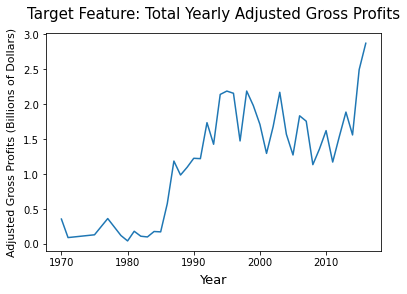

In [11]:
# Visualizations

# Target feature: inflation adjusted gross profits.
plt.plot(df.index.values, (df.inflation_adjusted_gross / 1000000000))
plt.title("Target Feature: Total Yearly Adjusted Gross Profits", fontsize=15, y=1.04)
plt.xlabel("Year", fontsize=13, labelpad=6)
plt.ylabel("Adjusted Gross Profits (Billions of Dollars)", fontsize=11, labelpad=6)
plt.show()
# plt.savefig("gross_profits")

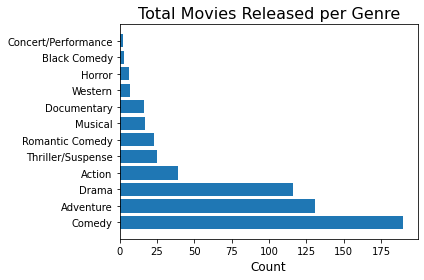

In [12]:
# Movies per genre visualization.
plt.barh(y=ddf_1.genre.value_counts().index, width=ddf_1.genre.value_counts().values)
plt.title("Total Movies Released per Genre", fontsize=16)
plt.xlabel("Count", fontsize=12)
plt.tight_layout()
plt.show()
# plt.savefig("movies_per_genre")

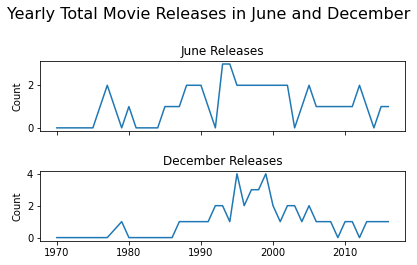

In [13]:
# Movie releases by month.
fig, axs = plt.subplots(2, 1, sharex=True)
fig.suptitle("Yearly Total Movie Releases in June and December", fontsize=16, y=0.94)
axs[0].plot(df.index.values, df.jun_release)
axs[0].set_title("June Releases")
axs[0].set_ylabel("Count")
axs[1].plot(df.index.values, df.dec_release)
axs[1].set_title("December Releases")
axs[1].set_ylabel("Count")
fig.tight_layout(pad=2)
plt.show()
# plt.savefig("monthly_releases")

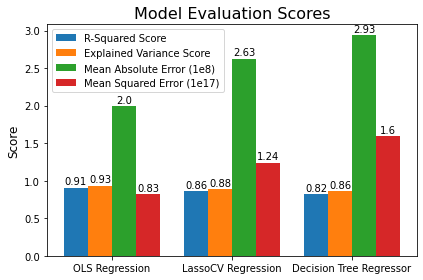

In [14]:
# Model Results Visualization.
labels = list(scores_df.columns)
r2s = np.array(scores_df.iloc[0, :])
evss = np.array(scores_df.iloc[1, :])
maes = np.array(scores_df.iloc[2, :])
maes_div = maes / 1e8
mses = np.array(scores_df.iloc[3, :])
mses_div = mses / 1e17
x = np.arange(len(labels))
width = 0.2
fig, ax = plt.subplots()
rects1 = ax.bar(x - width*1.5, r2s, width, label='R-Squared Score')
rects2 = ax.bar(x - width/2, evss, width, label='Explained Variance Score')
rects3 = ax.bar(x + width/2, maes_div, width, label='Mean Absolute Error (1e8)')
rects4 = ax.bar(x + width*1.5, mses_div, width, label='Mean Squared Error (1e17)')
ax.bar_label(rects1, labels=r2s.round(2), padding=1)
ax.bar_label(rects2, labels=evss.round(2), padding=1)
ax.bar_label(rects3, labels=maes_div.round(2), padding=1)
ax.bar_label(rects4, labels=mses_div.round(2), padding=1)
ax.set_title('Model Evaluation Scores', fontsize=16)
ax.set_ylabel('Score', fontsize=12)
ax.set_xticks(x, labels, fontsize=10)
ax.legend()
fig.tight_layout()
plt.show()
# plt.savefig('model_eval_scores')
